## Time Series Analysis: Forecasting Regional Electrical Demand

### Steps

* Loading the Data
* Basic EDA
* Exploring Drift and Seasonality
* Modeling Seasonal Background Load
* Load forecasting

In [28]:
import datetime as dt
import numpy as np
import pandas as pd

import scipy.fft

from sklearn import base
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [16]:
#!wget https://raw.githubusercontent.com/truggles/EIA_Cleaned_Hourly_Electricity_Demand_Data/master/data/release_2020_Oct/regions/NE.csv

In [2]:
df_NE = pd.read_csv('NE.csv')
df_NE.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43848 entries, 0 to 43847
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date_time            43848 non-null  object 
 1   raw demand (MW)      43848 non-null  float64
 2   cleaned demand (MW)  43848 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.0+ MB


In [3]:
df_NE.columns = df_NE.columns.str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
df_NE['date_time'] = pd.to_datetime(df_NE['date_time'])
df_NE.head()

,date_time,raw_demand_MW,cleaned_demand_MW
0,2015-07-02 00:00:00,17653.0,17653
1,2015-07-02 01:00:00,17286.0,17286
2,2015-07-02 02:00:00,16701.0,16701
3,2015-07-02 03:00:00,15220.0,15220
4,2015-07-02 04:00:00,13594.0,13594


In [4]:
df_NE.describe()

,date_time,raw_demand_MW,cleaned_demand_MW
count,43848,43848.000000,43848.000000
mean,2017-12-31 11:30:00,13874.842501,13875.772099
min,2015-07-02 00:00:00,0.000000,8494.000000
25%,2016-09-30 17:45:00,12011.000000,12011.000000
50%,2017-12-31 11:30:00,13588.000000,13588.500000
75%,2019-04-02 05:15:00,15310.000000,15310.000000
max,2020-07-01 23:00:00,25763.000000,25763.000000
std,NaN,2598.584172,2596.024883


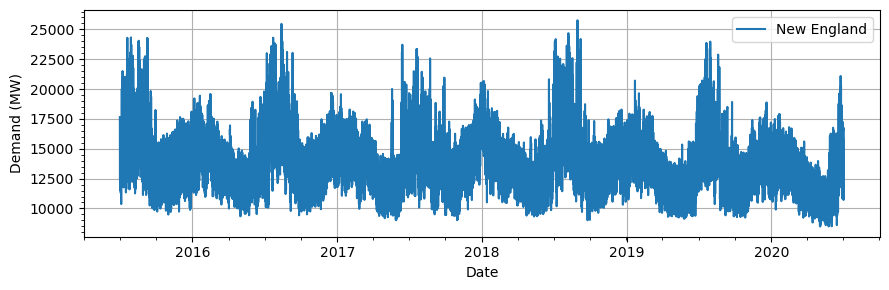

In [5]:
plt.figure(figsize=(9,3))
plt.plot(df_NE['date_time'], df_NE['cleaned_demand_MW'], label='New England')
plt.xlabel('Date')
plt.ylabel('Demand (MW)')
plt.minorticks_on()
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

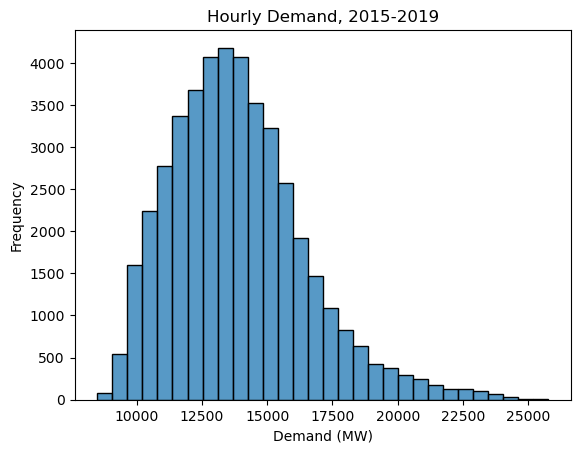

In [6]:
sns.histplot(data=df_NE, x='cleaned_demand_MW', bins=30)
plt.xlabel('Demand (MW)')
plt.ylabel('Frequency')
plt.title('Hourly Demand, 2015-2019')
plt.show()

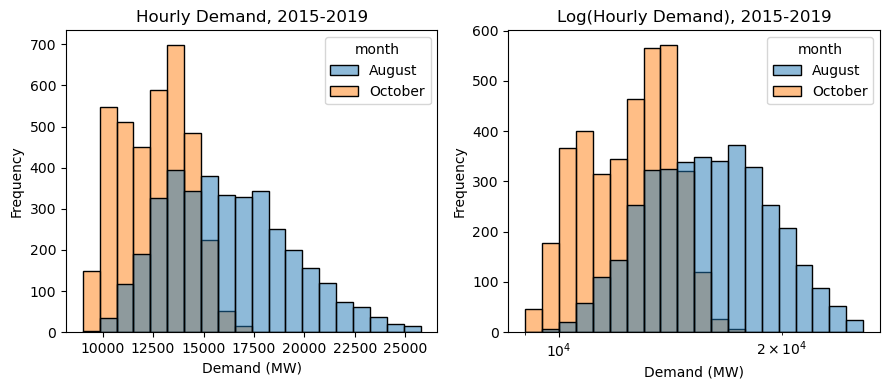

In [7]:
df_NE['month'] = df_NE['date_time'].dt.strftime('%B')

plotmonths = [8, 10]
df_seasonal = df_NE[df_NE['date_time'].dt.month.isin(plotmonths)]

fig, axes = plt.subplots(1, 2, figsize=(9, 4))

sns.histplot(data=df_seasonal, x='cleaned_demand_MW', bins=20, hue='month', ax=axes[0])
axes[0].set_xlabel('Demand (MW)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Hourly Demand, 2015-2019')

sns.histplot(data=df_seasonal, x='cleaned_demand_MW', bins=20, hue='month', log_scale=True, ax=axes[1])
axes[1].set_xlabel('Demand (MW)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Log(Hourly Demand), 2015-2019')

plt.tight_layout()
plt.show()

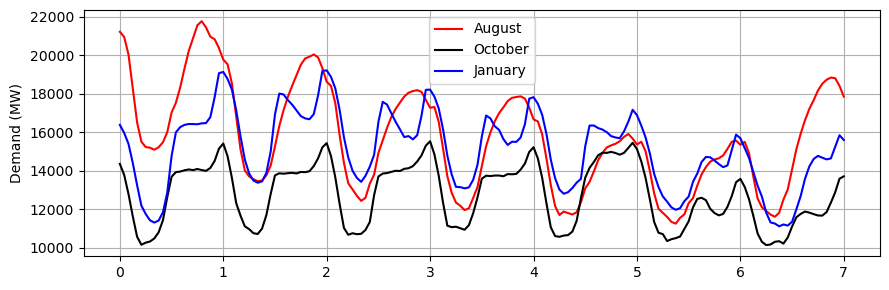

In [11]:
start_date1 = pd.to_datetime('2015-08-04 00:00:00')
end_date1 = pd.to_datetime('2015-08-11 00:00:00')

start_date2 = pd.to_datetime('2015-10-05 00:00:00')
end_date2 = pd.to_datetime('2015-10-12 00:00:00')

start_date3 = pd.to_datetime('2016-01-04 00:00:00')
end_date3 = pd.to_datetime('2016-01-11 00:00:00')

subset1 = df_NE.loc[(df_NE['date_time'] >= start_date1) & (df_NE['date_time'] <= end_date1)].copy()
subset2 = df_NE.loc[(df_NE['date_time'] >= start_date2) & (df_NE['date_time'] <= end_date2)].copy()
subset3 = df_NE.loc[(df_NE['date_time'] >= start_date3) & (df_NE['date_time'] <= end_date3)].copy()


plt.figure(figsize=(9,3))
plt.plot((subset1['date_time']-start_date1)/dt.timedelta(days=1), subset1['cleaned_demand_MW'], label='August', color='red')
plt.plot((subset2['date_time']-start_date2)/dt.timedelta(days=1), subset2['cleaned_demand_MW'], label='October', color='black')
plt.plot((subset3['date_time']-start_date3)/dt.timedelta(days=1), subset3['cleaned_demand_MW'], label='January', color='blue')
plt.ylabel('Demand (MW)')


plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

## Cross-validation for time series

In [54]:
columns = ['date_time', 'cleaned_demand_MW']

train_start = pd.to_datetime('2015-07-02 00:00:00')
train_end = pd.to_datetime('2018-07-01 23:00:00')

val_start = pd.to_datetime('2018-07-02 00:00:00')
val_end = pd.to_datetime('2019-07-01 23:00:00')

test_start = pd.to_datetime('2019-07-02 00:00:00')
test_end = pd.to_datetime('2020-07-01 23:00:00')

df_train = df_NE.loc[(df_NE['date_time'] >= train_start) & (df_NE['date_time'] <= train_end)].copy()[columns]
df_val = df_NE.loc[(df_NE['date_time'] >= val_start) & (df_NE['date_time'] <= val_end)].copy()[columns]
df_test = df_NE.loc[(df_NE['date_time'] >= test_start) & (df_NE['date_time'] <= test_end)].copy()[columns]

In [55]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26304 entries, 0 to 26303
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date_time          26304 non-null  datetime64[ns]
 1   cleaned_demand_MW  26304 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 616.5 KB


## Mean Model

A good baseline is the mean model, which has a MSE equal to the variance of the data. We'll take the square root to look at RMSE. Another metric we can consider is the 𝑅2 score. This will be very bad for the mean model. 

In [56]:
np.sqrt(df_val.cleaned_demand_MW.var())

2684.356183757364

In [57]:
metrics.r2_score(df_val.cleaned_demand_MW, [df_val.cleaned_demand_MW.mean()]*len(df_val.cleaned_demand_MW))

0.0

## Indicator Features Model

In [58]:
class HourofDay(base.BaseEstimator, base.TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def hour_vector(self, hour):
        v = np.zeros(24)
        v[hour] = 1
        return v
    
    def transform(self, X):
        return np.stack([self.hour_vector(h) for h in X.date_time.dt.hour])

In [59]:
class MonthofYear(base.BaseEstimator, base.TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def month_vector(self, month):
        v = np.zeros(12)
        v[month-1] = 1
        return v
    
    def transform(self, X):
        return np.stack([self.month_vector(m) for m in X.date_time.dt.month])

In [60]:
union = FeatureUnion([('monthofyear', MonthofYear()),
                      ('hourofday',HourofDay())])
indicator_pipe = Pipeline([('union', union),
                 ('lr', LinearRegression())])

In [61]:
indicator_model = indicator_pipe.fit(df_train, df_train.cleaned_demand_MW.astype('float64'))

In [76]:
y_train_pred = indicator_model.predict(df_train)
y_val_pred = indicator_model.predict(df_val)

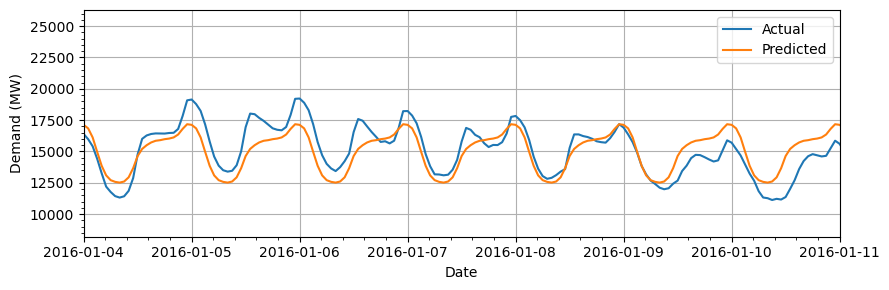

In [70]:
plt.figure(figsize=(9,3))
plt.plot(df_train['date_time'], df_train['cleaned_demand_MW'], label='Actual')
plt.plot(df_train['date_time'], y_train_pred, label='Predicted')
plt.xlim([pd.to_datetime('2016-01-04 00:00:00'), pd.to_datetime('2016-01-11 00:00:00')])
plt.xlabel('Date')
plt.ylabel('Demand (MW)')
plt.minorticks_on()
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

In [77]:
print("RMSE:", np.sqrt(metrics.mean_squared_error(df_train.cleaned_demand_MW.astype('float64'),
                                                  y_train_pred)))
print("R^2:", metrics.r2_score(df_train.cleaned_demand_MW.astype('float64'), y_train_pred))

RMSE: 1566.9013942028346
R^2: 0.6241589865106325


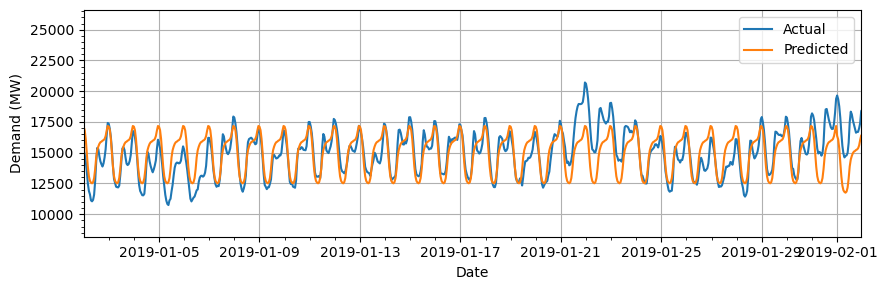

In [82]:
plt.figure(figsize=(9,3))
plt.plot(df_val['date_time'], df_val['cleaned_demand_MW'], label='Actual')
plt.plot(df_val['date_time'], y_val_pred, label='Predicted')
plt.xlim([pd.to_datetime('2019-01-02 00:00:00'), pd.to_datetime('2019-02-01 23:00:00')])
plt.xlabel('Date')
plt.ylabel('Demand (MW)')
plt.minorticks_on()
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

In [74]:
print("RMSE:", np.sqrt(metrics.mean_squared_error(df_val.cleaned_demand_MW.astype('float64'),
                                                  y_val_pred)))
print("R^2:", metrics.r2_score(df_val.cleaned_demand_MW.astype('float64'), y_val_pred))

RMSE: 1719.2596634816891
R^2: 0.5897465467280845


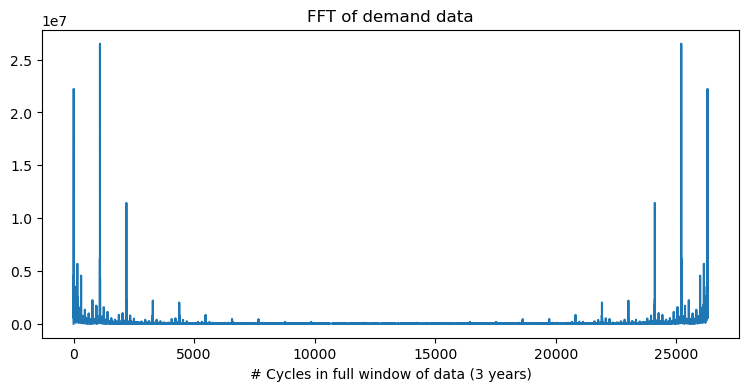

In [23]:
fft = scipy.fft.fft((df_train.cleaned_demand_MW - df_train.cleaned_demand_MW.mean()).values)
plt.figure(figsize=(9,4))
plt.plot(np.abs(fft))
plt.title("FFT of demand data")
plt.xlabel('# Cycles in full window of data (3 years)');

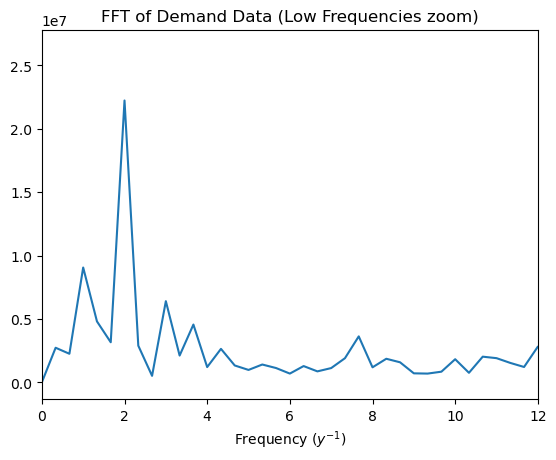

In [26]:
plt.plot(1./3 * np.arange(len(fft)), np.abs(fft))
plt.title("FFT of Demand Data (Low Frequencies zoom)")
plt.xlim([0,12])
plt.xlabel('Frequency ($y^{-1}$)');

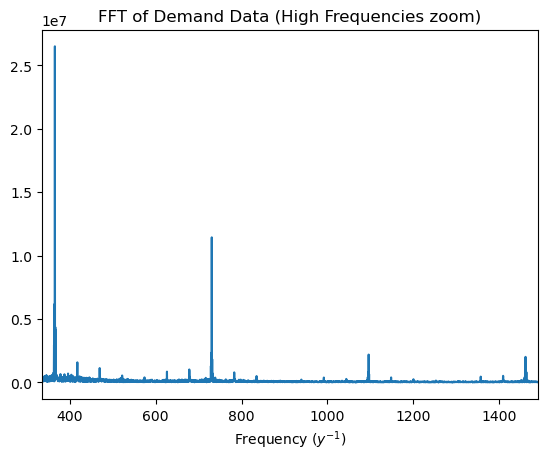

In [79]:
daily_cycles_in_5_years = 5*365

plt.plot(1./3 * np.arange(len(fft)), np.abs(fft))
plt.title("FFT of Demand Data (High Frequencies zoom)")
#plt.ylim([0,400000])
plt.xlim([365 - 30, (365*4) + 30])
plt.xlabel('Frequency ($y^{-1}$)');

In [49]:
#df_NE['day_of_week'] = df_NE['date_time'].dt.strftime('%A')
df_NE['day_of_week'] = df_NE['date_time'].dt.day_name()